# How does Twitter discuss trans people?

We have searched for the following terms:
- trans people
- transgender

In [1]:
import pandas as pd

from utils.df_imports import read_jsonl_gz

PATHS = [
    '../data/search_trans_people.jsonl.gz',
    '../data/search_transgender.jsonl.gz'
]

raw_tweet_df = pd.concat([read_jsonl_gz(path) for path in PATHS])
raw_tweet_df.drop_duplicates('id', inplace=True)

raw_tweet_df

,tweet,author,date,id
0,RT @AriDrennen: 🚨The Texas Senate just approve...,Chococoder,2021-04-28 03:05:19,1387241491169480707
1,RT @zoewhittall: What @TheCurrentCBC is ignori...,sexisnonbinary,2021-04-28 03:05:03,1387241423293108236
2,"17 vs now\n\nHonestly, why does anyone but tra...",Ranting_Trans,2021-04-28 03:05:01,1387241412576505857
3,"RT @cmclymer: ""Understand the fuller context h...",jay_james84,2021-04-28 03:05:01,1387241412329095179
4,RT @zoewhittall: What @TheCurrentCBC is ignori...,IvaCheung,2021-04-28 03:04:58,1387241400371089408
...,...,...,...,...
150088,@Ditzy771 @CeeBee64495886 Then it would be mor...,Marina19226553,2021-04-19 21:32:25,1384258608544686087
150089,Activists sue to keep number of transgender in...,debbies3360,2021-04-19 21:32:19,1384258583462772742
150090,John Bel Edwards won't support bills that ban ...,DarthDandious,2021-04-19 21:32:14,1384258562675806216
150091,local transgender makes 'love' on personal grass,localwebwebs,2021-04-19 21:31:26,1384258360199979010


## Preliminary Data Cleaning Steps

In [2]:
tweet_df = raw_tweet_df
#tweet_df = tweet_df[~tweet_df['tweet'].str.startswith('RT @')]  # remove retweets?

## N-gram hits

[nltk_data] Downloading package stopwords to /home/astrid/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/astrid/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


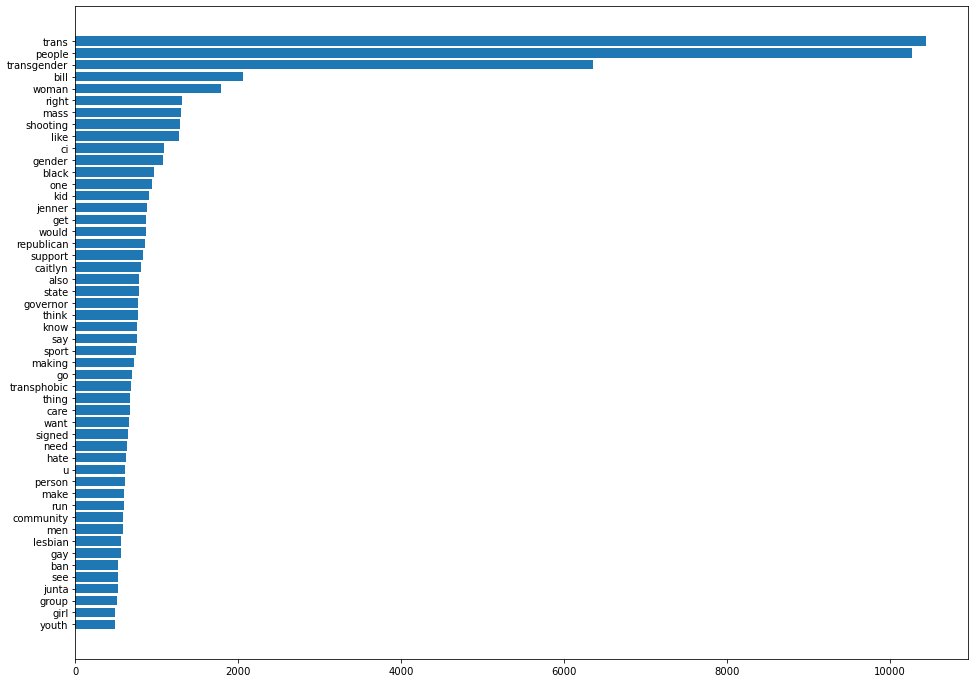

In [3]:
from utils.tokens import build_stopword_set, plot_ngrams
import matplotlib.pyplot as plt

stop = build_stopword_set()

_, ax = plt.subplots(1, 1, figsize=(16, 12))
plot_ngrams(ax, tweet_df['tweet'].sample(20000), stop, ngram_size=1)
plt.show()

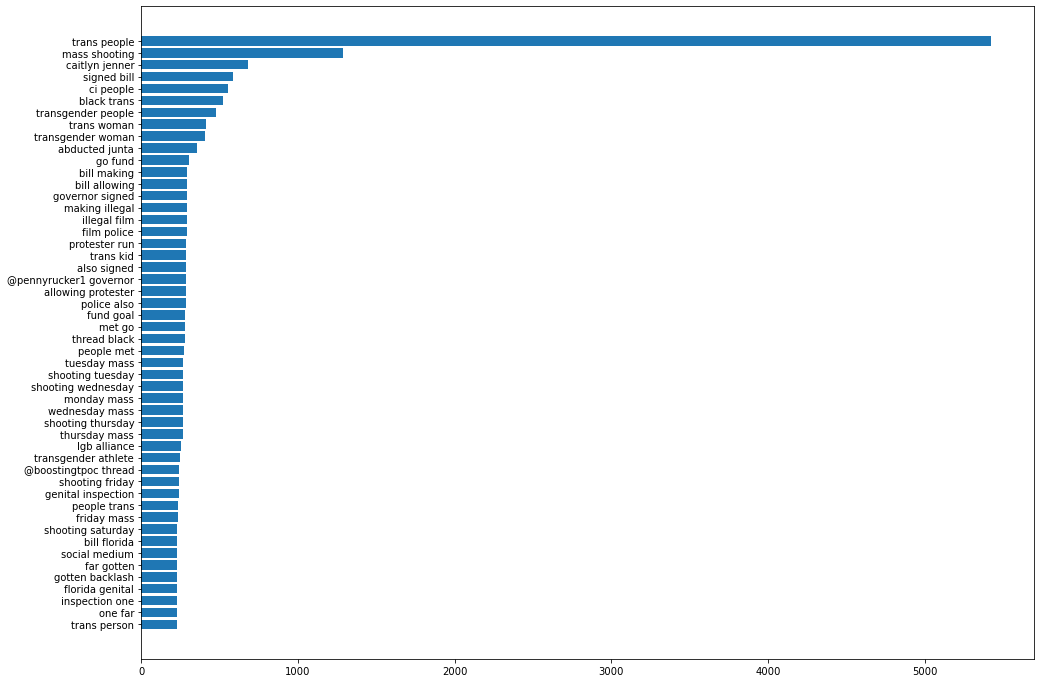

In [4]:
_, ax = plt.subplots(1, 1, figsize=(16, 12))
plot_ngrams(ax, tweet_df['tweet'].sample(20000), stop, ngram_size=2)
plt.show()

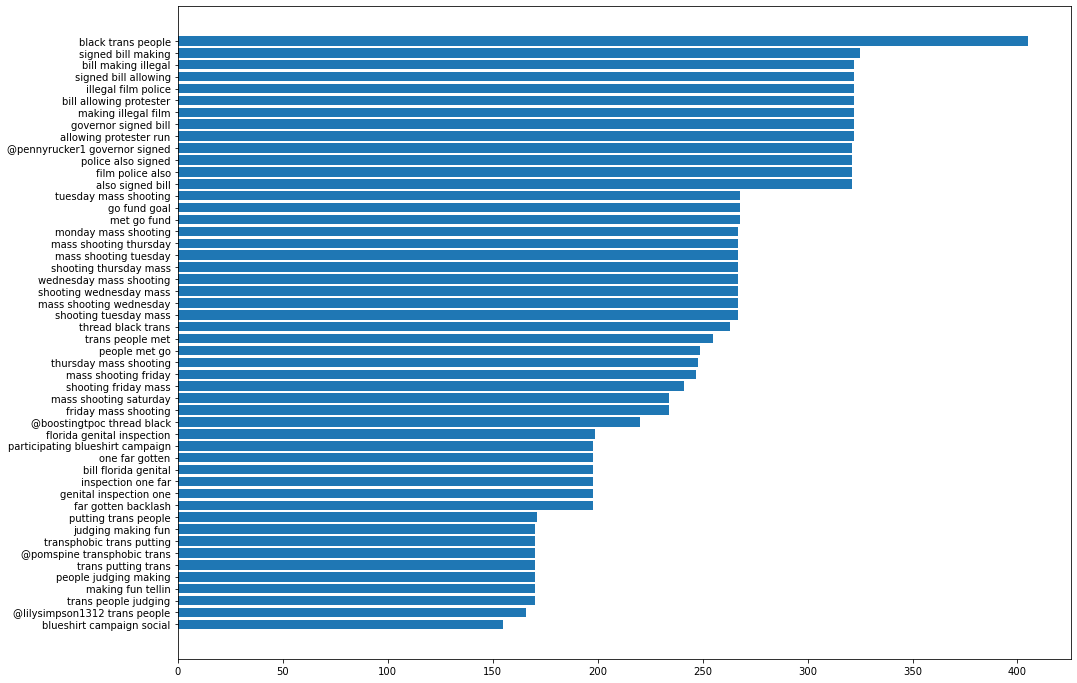

In [5]:
_, ax = plt.subplots(1, 1, figsize=(16, 12))
plot_ngrams(ax, tweet_df['tweet'].sample(20000), stop, ngram_size=3)
plt.show()

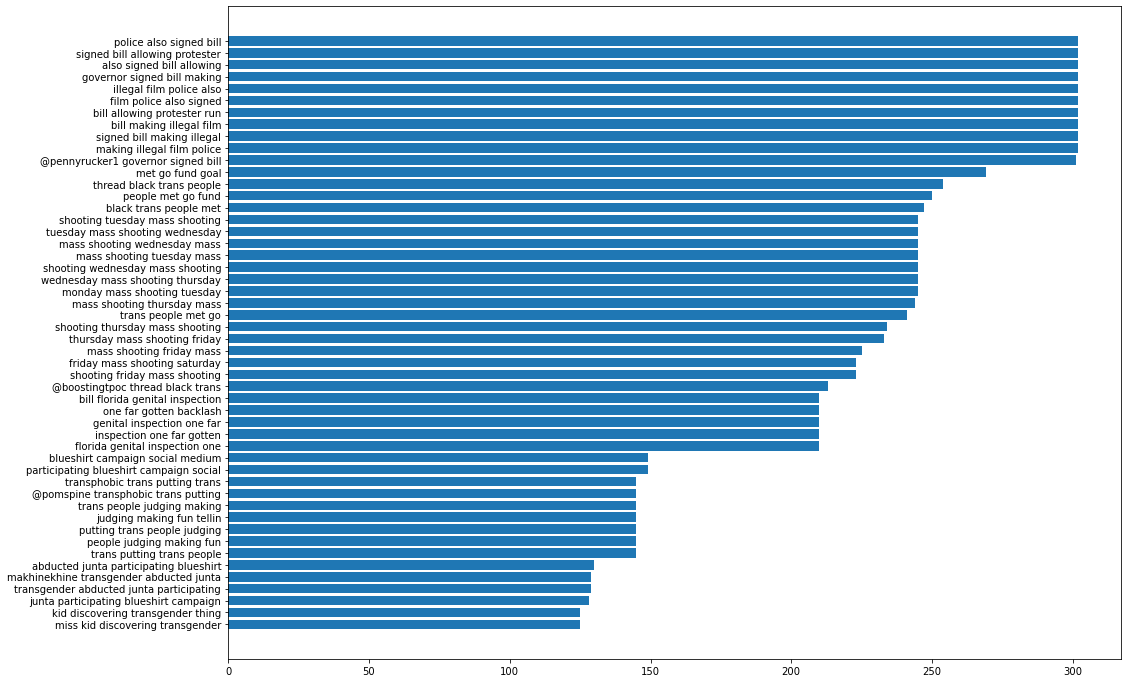

In [6]:
_, ax = plt.subplots(1, 1, figsize=(16, 12))
plot_ngrams(ax, tweet_df['tweet'].sample(20000), stop, ngram_size=4)
plt.show()

### Interesting notes

1. There is mention of the Myanmar coup, which abducted and attacked Mingalar Taungnyunt, a trans woman protestor (`transgender abducted junta` with 270 hits)
2. A mass shooting on Thursday performed by a trans man (250 ish hits)
3. Caitlyn Jenner running for governor (`caitlyn jenner` with ~750 hits)
4. BLM riots?
5. `@boostingtpoc thread black` trans people who have not met their go fund me goals
6. Various bills where republicans attack trans people in women's sports
    - `florida genital inspection` with 250 hits
    - `texas senate approved sb1646` with 150 hits
    - Non-trans, but also Republican bills get included in these mentions (i.e. illegal to film police, the running over protestors bill)
7. Something about judging trans people (170 hits)
8. Mentions of kids discovering this transgender thing (150 hits)

Let's go with **15** LDA topics.

## LDA Time

### Build dictionary and train TF-IDF

In [7]:
import utils.tokens as ut
import logging

import gensim

# Enable logging
logging.basicConfig(format='%(asctime)s %(levelname)s : %(message)s', level=logging.INFO)

ranged_df = tweet_df
documents = list(ut.tokenize_tweets(ranged_df['tweet'], stop))
dictionary = gensim.corpora.Dictionary(documents)

bow_corpus = [dictionary.doc2bow(doc) for doc in documents]
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

2021-05-02 11:25:30,345 INFO : adding document #0 to Dictionary(0 unique tokens: [])
2021-05-02 11:25:30,481 INFO : adding document #10000 to Dictionary(10659 unique tokens: ['@aridrennen', 'affirming', 'approved', 'ban', 'gender']...)
2021-05-02 11:25:30,653 INFO : adding document #20000 to Dictionary(17408 unique tokens: ['@aridrennen', 'affirming', 'approved', 'ban', 'gender']...)
2021-05-02 11:25:30,798 INFO : adding document #30000 to Dictionary(21464 unique tokens: ['@aridrennen', 'affirming', 'approved', 'ban', 'gender']...)
2021-05-02 11:25:30,959 INFO : adding document #40000 to Dictionary(25684 unique tokens: ['@aridrennen', 'affirming', 'approved', 'ban', 'gender']...)
2021-05-02 11:25:31,107 INFO : adding document #50000 to Dictionary(29552 unique tokens: ['@aridrennen', 'affirming', 'approved', 'ban', 'gender']...)
2021-05-02 11:25:31,261 INFO : adding document #60000 to Dictionary(33344 unique tokens: ['@aridrennen', 'affirming', 'approved', 'ban', 'gender']...)
2021-05-0

### Train the LDA model

Since this takes a while, we will only do it on a random sample of documents.
We start with 300k tweets so let's run on a sample of 30k.

In [14]:
import random

TOPICS = 15

lda_sample = random.choices(corpus_tfidf, k=30_000)
lda_model_tfidf = gensim.models.LdaMulticore(lda_sample, num_topics=TOPICS, id2word=dictionary, passes=5, workers=8)
lda_model_tfidf

2021-05-02 11:28:55,628 INFO : using symmetric alpha at 0.06666666666666667
2021-05-02 11:28:55,629 INFO : using symmetric eta at 0.06666666666666667
2021-05-02 11:28:55,640 INFO : using serial LDA version on this node
2021-05-02 11:28:55,746 INFO : running online LDA training, 15 topics, 5 passes over the supplied corpus of 30000 documents, updating every 16000 documents, evaluating every ~30000 documents, iterating 50x with a convergence threshold of 0.001000
2021-05-02 11:28:55,746 WARNING : too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2021-05-02 11:28:55,747 INFO : training LDA model using 8 processes
2021-05-02 11:28:56,088 INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/30000, outstanding queue size 1
2021-05-02 11:28:56,283 INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/30000, outstanding queue size 2
2021-05-02 11:28:56,285 INFO : PROGRESS: pass 0, dispatched c

### Topics and words

In [16]:
for idx, topic in lda_model_tfidf.print_topics(-1, num_words=10):
    print('{}\t{}'.format(idx, topic))

2021-05-02 11:29:20,705 INFO : topic #0 (0.067): 0.010*"transgender" + 0.006*"trans" + 0.006*"day" + 0.006*"people" + 0.006*"openly" + 0.005*"@lilysimpson1312" + 0.005*"around" + 0.005*"woman" + 0.004*"jenner" + 0.004*"caitlyn"
2021-05-02 11:29:20,708 INFO : topic #1 (0.067): 0.009*"discovering" + 0.008*"miss" + 0.006*"kid" + 0.006*"thing" + 0.006*"degrades" + 0.006*"@jayhulmepoet" + 0.006*"aware" + 0.005*"alliance" + 0.005*"lgb" + 0.005*"may"
2021-05-02 11:29:20,710 INFO : topic #2 (0.067): 0.008*"junta" + 0.006*"abducted" + 0.006*"campaign" + 0.005*"blueshirt" + 0.005*"khaing" + 0.005*"participating" + 0.004*"#whatshappeninginmyanmar" + 0.004*"transgender" + 0.004*"social" + 0.004*"medium"
2021-05-02 11:29:20,711 INFO : topic #3 (0.067): 0.005*"people" + 0.005*"lesbian" + 0.005*"trans" + 0.004*"please" + 0.003*"ci" + 0.003*"stop" + 0.003*"forcing" + 0.003*"support" + 0.003*"stormed" + 0.002*"maker"
2021-05-02 11:29:20,713 INFO : topic #4 (0.067): 0.004*"receiving" + 0.004*"transgende

0	0.010*"transgender" + 0.006*"trans" + 0.006*"day" + 0.006*"people" + 0.006*"openly" + 0.005*"@lilysimpson1312" + 0.005*"around" + 0.005*"woman" + 0.004*"jenner" + 0.004*"caitlyn"
1	0.009*"discovering" + 0.008*"miss" + 0.006*"kid" + 0.006*"thing" + 0.006*"degrades" + 0.006*"@jayhulmepoet" + 0.006*"aware" + 0.005*"alliance" + 0.005*"lgb" + 0.005*"may"
2	0.008*"junta" + 0.006*"abducted" + 0.006*"campaign" + 0.005*"blueshirt" + 0.005*"khaing" + 0.005*"participating" + 0.004*"#whatshappeninginmyanmar" + 0.004*"transgender" + 0.004*"social" + 0.004*"medium"
3	0.005*"people" + 0.005*"lesbian" + 0.005*"trans" + 0.004*"please" + 0.003*"ci" + 0.003*"stop" + 0.003*"forcing" + 0.003*"support" + 0.003*"stormed" + 0.002*"maker"
4	0.004*"receiving" + 0.004*"transgender" + 0.004*"youth" + 0.004*"testified" + 0.004*"army" + 0.003*"death" + 0.003*"@aclu" + 0.003*"threat" + 0.003*"fight" + 0.003*"bill"
5	0.005*"difficult" + 0.004*"life" + 0.004*"trans" + 0.004*"people" + 0.003*"transphobia" + 0.002*"je

### Topic Identification

#### Terms related to the state anti-trans bills

In [21]:
def sum_of_scores(tweets):
    bows = [bow_corpus[i] for i in tweets.index]
    topic_scores = [0 for _ in range(TOPICS)]

    for tweet_topics in lda_model_tfidf[bows]:
        for idx, score in tweet_topics:
            topic_scores[idx] += score

    topics = list(enumerate(topic_scores))
    topics.sort(key=lambda pair: pair[1], reverse=True)
    return topics


def tweets_containing_term(term):
    return tweet_df[tweet_df['tweet'].str.lower().str.find(term) > 0]


sum_of_scores(tweets_containing_term('senat'))  # to include senate, senator

[(7, 1868.374259843491),
 (10, 267.7916420372203),
 (3, 263.9350234437734),
 (0, 206.89644672814757),
 (5, 176.90519787278026),
 (11, 120.8510729232803),
 (8, 117.47676487267017),
 (12, 115.21897361427546),
 (2, 104.37499126046896),
 (14, 83.89435793273151),
 (4, 80.76448140386492),
 (1, 61.46581892389804),
 (6, 60.69001624453813),
 (9, 34.2646988267079),
 (13, 24.07595068309456)]

In [32]:
sum_of_scores(tweets_containing_term('sport'))

[(3, 1919.3613846590742),
 (10, 1491.8280525431037),
 (0, 1316.9581971401349),
 (5, 810.5914940889925),
 (8, 803.6112671103328),
 (2, 681.2491600699723),
 (11, 638.3824345041066),
 (14, 500.86973120085895),
 (7, 475.5048852227628),
 (12, 446.42454228177667),
 (6, 356.0138635719195),
 (4, 334.22452491428703),
 (1, 321.5525727169588),
 (9, 282.380030868575),
 (13, 187.7958778589964)]

#### Terms related to Myanmar

In [33]:
sum_of_scores(tweets_containing_term('myanmar'))

[(3, 721.0356190418825),
 (8, 500.24418291449547),
 (0, 488.5726017160341),
 (7, 484.01626003999263),
 (5, 353.31408667657524),
 (10, 335.1006881771609),
 (11, 255.8316267002374),
 (14, 219.2526523154229),
 (9, 217.36259201727808),
 (2, 166.48218283057213),
 (4, 134.16909776441753),
 (6, 120.07455379515886),
 (12, 77.50395813211799),
 (1, 68.53813492506742),
 (13, 48.91300072334707)]

In [34]:
sum_of_scores(tweets_containing_term('junta'))

[(3, 1125.3384990599006),
 (0, 744.354977818206),
 (8, 700.4835152504966),
 (7, 589.4484194563702),
 (10, 548.2460211580619),
 (5, 524.3173602735624),
 (14, 353.24097402300686),
 (11, 343.50613409560174),
 (9, 289.1016712458804),
 (4, 244.03420997969806),
 (2, 228.977622712031),
 (6, 192.19466665945947),
 (1, 114.96556888241321),
 (12, 107.53911217302084),
 (13, 61.47893883753568)]

#### Caitlyn Jenner

In [27]:
sum_of_scores(tweets_containing_term('caitlyn'))

[(10, 2684.220008296892),
 (0, 2198.007227377966),
 (8, 2130.8854262186214),
 (3, 1610.7006006622687),
 (5, 1484.1913184653968),
 (12, 958.0290026245639),
 (14, 494.09203288238496),
 (11, 483.0935956798494),
 (9, 431.21810378320515),
 (2, 262.1860240092501),
 (1, 244.83235368598253),
 (13, 226.59801193978637),
 (4, 211.84409947600216),
 (7, 200.6631902353838),
 (6, 173.84595738071948)]

In [36]:
sum_of_scores(tweets_containing_term('jenner'))

[(10, 2974.692292008549),
 (0, 2572.434284265153),
 (8, 2401.461598438211),
 (3, 2100.143870729953),
 (5, 2095.1558044413105),
 (12, 1018.9988404475152),
 (11, 673.6090467860922),
 (14, 585.3127866899595),
 (9, 494.6567849852145),
 (7, 341.0682308282703),
 (2, 336.7616101568565),
 (13, 291.3793874103576),
 (1, 287.96508335135877),
 (4, 254.14591382071376),
 (6, 205.41546732746065)]

In [35]:
sum_of_scores(tweets_containing_term('governor'))

[(3, 1761.3279034029692),
 (0, 1475.4583218358457),
 (10, 1431.7645849166438),
 (5, 1031.057516509667),
 (8, 900.3686876138672),
 (11, 771.0352229243144),
 (2, 769.5688773319125),
 (14, 613.9891324723139),
 (12, 390.29559964034706),
 (6, 367.09837873559445),
 (9, 333.60395606420934),
 (4, 283.8636489454657),
 (1, 280.6188354101032),
 (13, 191.67666310165077),
 (7, 186.33749418426305)]